In [1]:
import cv2
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
n_classes = 6
seed = 24
batch_size = 8
epochs = 100
learning_rate = 1e-3
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
model_file = '../models/unet_model.keras'
train_image_path = "../dataset/256_patches_splitted_RF/train/images"
train_mask_path = "../dataset/256_patches_splitted_RF/train/masks"
val_image_path = "../dataset/256_patches_splitted_RF/val/images"
val_mask_path = "../dataset/256_patches_splitted_RF/val/masks"
test_image_path = "../dataset/256_patches_splitted_RF/test/images"
test_mask_path = "../dataset/256_patches_splitted_RF/test/masks"
color_map = {
    0: [0, 0, 0],  # Background (unlabeled - black)
    1: [255, 0, 0],  # Class 1 (building - #FF0000)
    2: [255, 105, 180],  # Class 2 (water - #FF69B4 )
    3: [65, 117, 5],  # Class 3 (tree - #417505)
    4: [126, 211, 33],  # Class 4 (grass - #7ED321)
    5: [169, 169, 169],  # Class 5 (road - #A9A9A9)
    6: [139, 87, 42]  # Class 6 (soil - #8B572A)
}

In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras import backend as K


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [4]:

# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, \
    Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x


#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)
    b1 = conv_block(p4, 256)  #Bridge

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [5]:
def get_items(directory_path, type):
    image_dataset = []
    for subfile in os.listdir(directory_path):
        image = cv2.imread(directory_path + '/' + subfile)
        if type == "image":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_dataset.append(image)
    image_dataset = np.array(image_dataset)
    return image_dataset

In [6]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

label_encoder = LabelEncoder()
scaler = MinMaxScaler()
X_train = get_items(train_image_path, "image")
X_val = get_items(val_image_path, "image")
X_test = get_items(test_image_path, "image")
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.fit_transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
# X_train = preprocess_input(X_train)
# X_val = preprocess_input(X_val)
# X_test = preprocess_input(X_test)
print("X_train: %s , X_val: %s , X_test: %s" % (X_train.shape, X_val.shape, X_test.shape))
Y_train = get_items(train_mask_path, "mask")
Y_val = get_items(val_mask_path, "mask")
Y_test = get_items(test_mask_path, "mask")
Y_train = label_encoder.fit_transform(np.ravel(Y_train)).reshape(Y_train.shape)
Y_test = label_encoder.fit_transform(np.ravel(Y_test)).reshape(Y_test.shape)
Y_val = label_encoder.fit_transform(np.ravel(Y_val)).reshape(Y_val.shape)
print("Y_train: %s , Y_val: %s , Y_test: %s" % (Y_train.shape, Y_val.shape, Y_test.shape))
print(np.unique(Y_train))

X_train: (72, 256, 256, 3) , X_val: (24, 256, 256, 3) , X_test: (24, 256, 256, 3)
Y_train: (72, 256, 256) , Y_val: (24, 256, 256) , Y_test: (24, 256, 256)
[0 1 2 3 4 5]


In [7]:
from keras.utils import to_categorical

Y_train_cat = to_categorical(Y_train, num_classes=n_classes)
Y_val_cat = to_categorical(Y_val, num_classes=n_classes)
Y_test_cat = to_categorical(Y_test, num_classes=n_classes)
print("Y_train_cat: %s , Y_val_cat: %s , Y_test_cat: %s" % (Y_train_cat.shape, Y_val_cat.shape, Y_test_cat.shape))

Y_train_cat: (72, 256, 256, 6) , Y_val_cat: (24, 256, 256, 6) , Y_test_cat: (24, 256, 256, 6)


In [8]:
# from keras.preprocessing.image import ImageDataGenerator
# 
# datagen = ImageDataGenerator(horizontal_flip=True,
#                              vertical_flip=True,
#                              fill_mode='reflect')
# train_gen = datagen.flow(X_train, Y_train_cat, batch_size=batch_size, shuffle=True, seed=seed)
# val_gen = datagen.flow(X_val, Y_val_cat, batch_size=batch_size, shuffle=False, seed=seed)
# test_gen = datagen.flow(X_test, Y_test_cat, batch_size=batch_size, shuffle=False, seed=seed)

In [10]:
metrics = ['accuracy', jacard_coef]
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [10]:
# # weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
# # dice_loss = sm.losses.DiceLoss(class_weights=weights)
# # focal_loss = sm.losses.CategoricalFocalLoss()
# # total_loss = dice_loss + (1 * focal_loss)
# 
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.preprocessing import MultiLabelBinarizer
# 
# 
# def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
#     if multi_class:
#         # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
#         if one_hot_encoded:
#             class_series = np.argmax(class_series, axis=1)
# 
#         # Compute class weights with sklearn method
#         class_labels = np.unique(class_series)
#         class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
#         return dict(zip(class_labels, class_weights))
#     else:
#         # It is neccessary that the multi-label values are one-hot encoded
#         mlb = None
#         if not one_hot_encoded:
#             mlb = MultiLabelBinarizer()
#             class_series = mlb.fit_transform(class_series)
# 
#         n_samples = len(class_series)
# 
#         # Count each class frequency
#         class_count = [0] * n_classes
#         for classes in class_series:
#             for index in range(n_classes):
#                 if classes[index] != 0:
#                     class_count[index] += 1
# 
#         # Compute class weights using balanced method
#         class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
#         class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
#         return dict(zip(class_labels, class_weights))
# 
# 
# weights = generate_class_weights(Y_train.reshape(-1))
# print(weights)
# weights = {0: 0.1666, 1: 0.1666, 2: 0.1666, 3: 0.1666, 4: 0.1666, 5: 0.1666}

In [11]:
# weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
# import segmentation_models as sm
# 
# dice_loss = sm.losses.DiceLoss(class_weights=weights)
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

In [11]:
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
# model = build_unet(input_shape, n_classes)

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=metrics)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_18[0][0]']          
                                                                                            

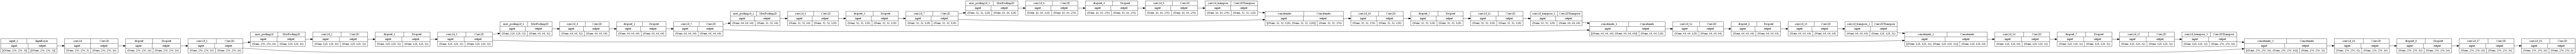

In [14]:
# from keras.utils import plot_model
# 
# plot_model(model, to_file="../plot_model/unet_model.png", rankdir="LR" , show_shapes=True, show_layer_names=True)

In [126]:
tf.keras.backend.clear_session()
history = model.fit(X_train, Y_train_cat, batch_size=batch_size, verbose=1, epochs=epochs,
                    validation_data=(X_val, Y_val_cat),
                    # class_weight=weights,
                    callbacks=callbacks)
model.save(model_file)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 1.7275 - accuracy: 0.3690 - jacard_coef: 0.1004
Epoch 1: val_loss improved from inf to 1.61563, saving model to ../models\unet_model.keras
9/9 [==============================] - 10s 815ms/step - loss: 1.7275 - accuracy: 0.3690 - jacard_coef: 0.1004 - val_loss: 1.6156 - val_accuracy: 0.4092 - val_jacard_coef: 0.1114 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 1.5278 - accuracy: 0.4525 - jacard_coef: 0.1447
Epoch 2: val_loss improved from 1.61563 to 1.24184, saving model to ../models\unet_model.keras
9/9 [==============================] - 7s 779ms/step - loss: 1.5278 - accuracy: 0.4525 - jacard_coef: 0.1447 - val_loss: 1.2418 - val_accuracy: 0.4150 - val_jacard_coef: 0.2066 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 1.1842 - accuracy: 0.4639 - jacard_coef: 0.2561
Epoch 3: val_loss improved from 1.24184 to 1.17632, saving model to ../models\unet_model

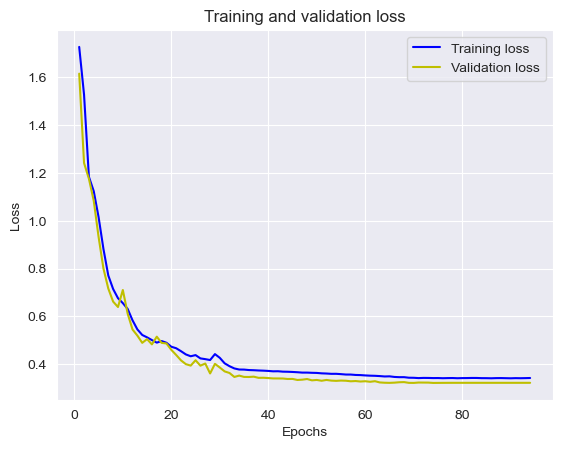

In [127]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

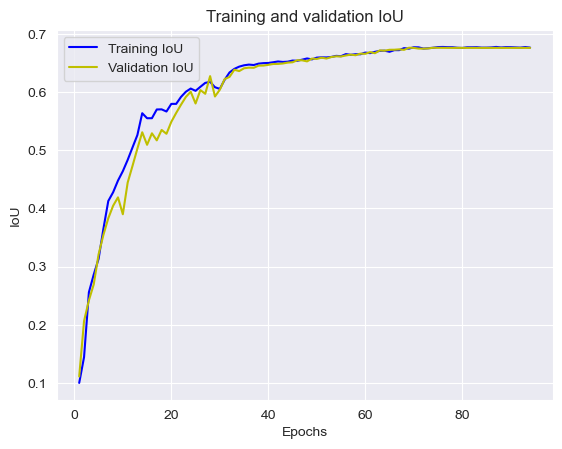

In [128]:
iou = history.history['jacard_coef']
val_iou = history.history['val_jacard_coef']

plt.plot(epochs, iou, 'b', label='Training IoU')
plt.plot(epochs, val_iou, 'y', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [8]:
from keras.models import load_model

from tensorflow.keras.losses import Loss

model = load_model(model_file,
                   custom_objects=({
                       'jacard_coef': jacard_coef}))


In [131]:
from keras.metrics import MeanIoU

Y_pred = model.predict(X_test)
print(Y_pred.shape)
print(Y_test.shape)
Y_pred_argmax = np.argmax(Y_pred, axis=3)
# Y_test_argmax = np.argmax(Y_test, axis=3)
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(Y_test, Y_pred_argmax)
# Accuracy_keras = Accuracy(num_classes=n_classes)
# Accuracy_keras.update_state(Y_test_argmax, Y_pred_argmax)
# print("Accuracy =", Accuracy_keras.result().numpy())
print("Mean IOU =", IOU_keras.result().numpy())

1/1 [==============================] - 1s 684ms/step
(24, 256, 256, 6)
(24, 256, 256)
Mean IOU = 0.5950566


In [132]:
from keras.metrics import Accuracy

Accuracy_keras = Accuracy()
Accuracy_keras.update_state(Y_test, Y_pred_argmax)
print("Test accuracy =", Accuracy_keras.result().numpy())

Test accuracy = 0.8528417


In [133]:
image_directory3 = "../dataset/256_patches_splitted/test/images"
for subdir in os.listdir(image_directory3):
    print("Predict image : " + subdir)
    img = cv2.imread(image_directory3 + "/" + subdir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img = np.expand_dims(img, axis=0)
    result = model.predict(test_img)
    segmented_result = np.argmax(result, axis=3)[0, :, :]
    segmented_result = cv2.convertScaleAbs(segmented_result)
    cv2.imwrite('../results/UNET/' + subdir, segmented_result)

Predict image : image_patch_11.tif
1/1 [==============================] - 0s 223ms/step
Predict image : image_patch_17.tif
1/1 [==============================] - 0s 45ms/step
Predict image : image_patch_210.tif
1/1 [==============================] - 0s 43ms/step
Predict image : image_patch_311.tif
1/1 [==============================] - 0s 48ms/step
Predict image : image_patch_34.tif
1/1 [==============================] - 0s 42ms/step
Predict image : image_patch_38.tif
1/1 [==============================] - 0s 41ms/step
Predict image : image_patch_41.tif
1/1 [==============================] - 0s 45ms/step
Predict image : image_patch_410.tif
1/1 [==============================] - 0s 46ms/step
Predict image : image_patch_56.tif
1/1 [==============================] - 0s 44ms/step
Predict image : image_patch_61.tif
1/1 [==============================] - 0s 44ms/step
Predict image : image_patch_610.tif
1/1 [==============================] - 0s 53ms/step
Predict image : image_patch_65.tif
1/1

[0 1 2 3 4 5]


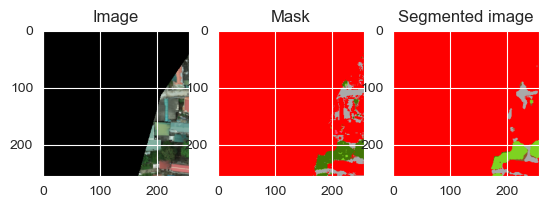

[0 2 3 4 5]


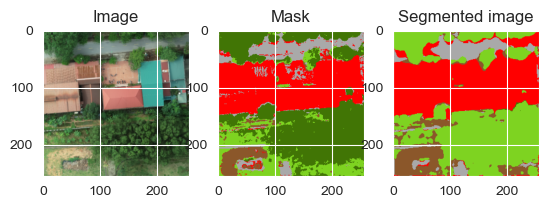

[0 2 3 4 5]


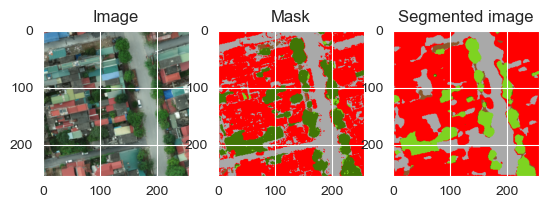

[0 2 3 4 5]


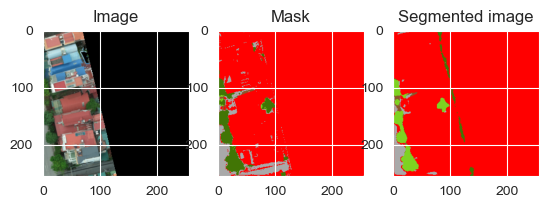

[0 2 3 4 5]


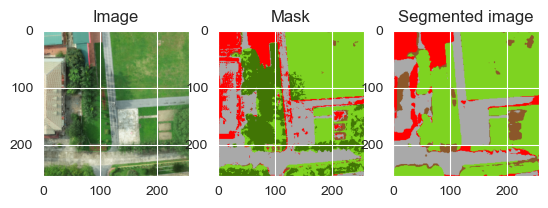

[0 2 3 4 5]


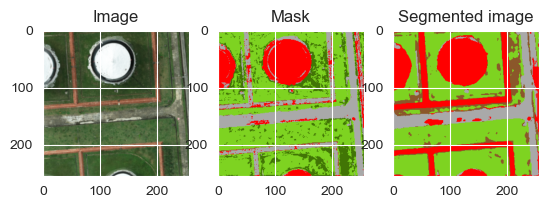

[0 2 3 4 5]


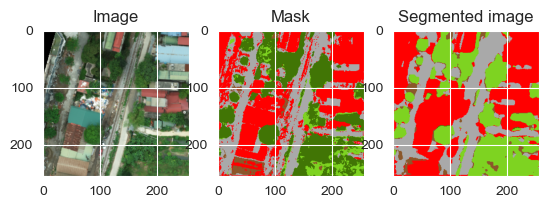

[0 2 3 4 5]


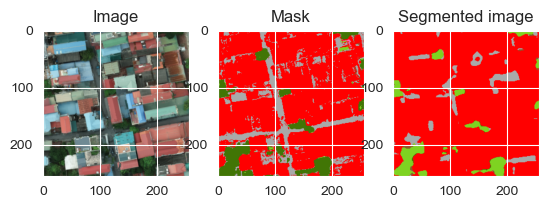

[0 2 3 4 5]


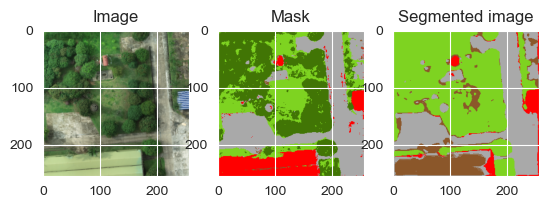

[0 2 3 4 5]


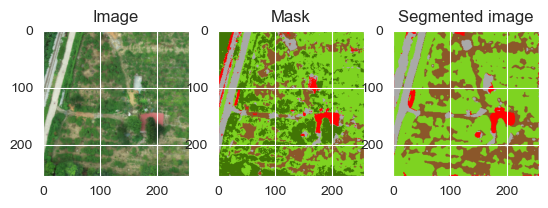

[0 2 3 4 5]


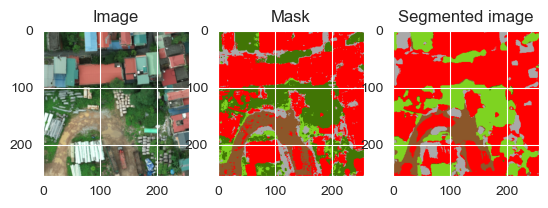

[0 1 2 3 4 5]


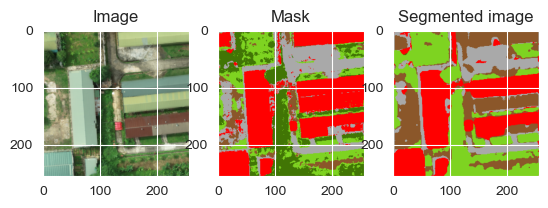

[0 2 3 4 5]


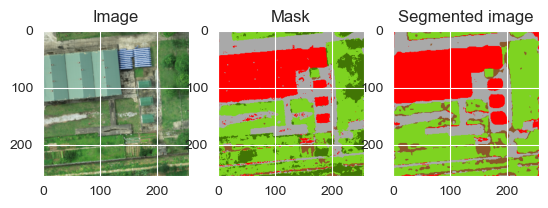

[0 2 3 4 5]


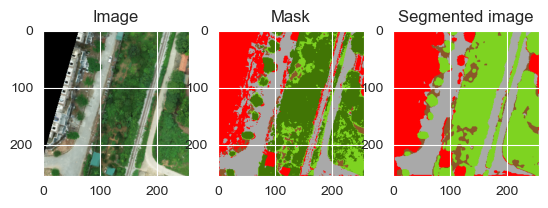

[0 2 3 4 5]


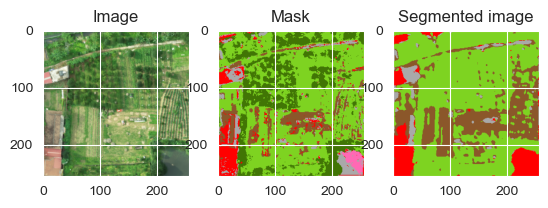

[0 2 3 4 5]


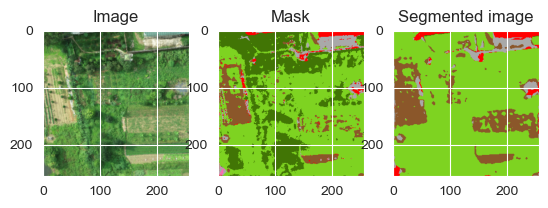

[0 1 2 3 4 5]


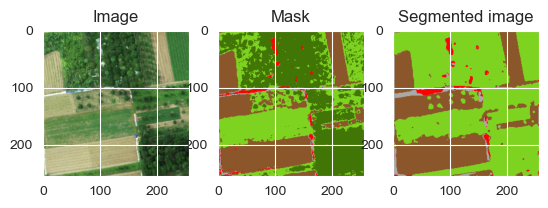

[0 2 3 4 5]


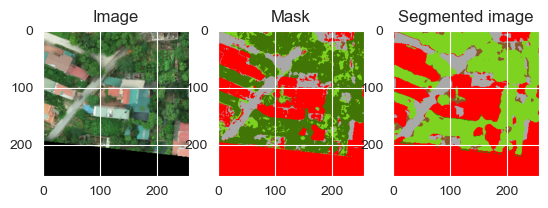

[0 2 3 4 5]


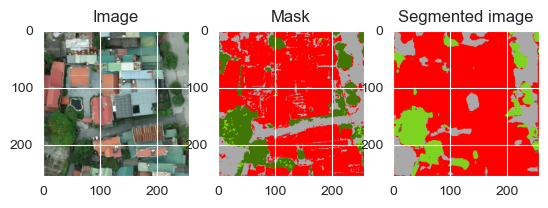

[0 2 3 4 5]


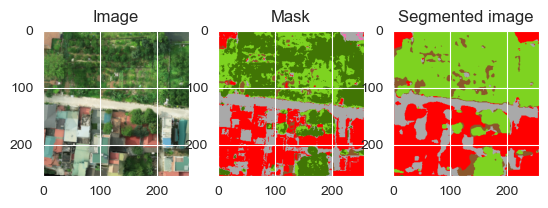

[0 2 3 4 5]


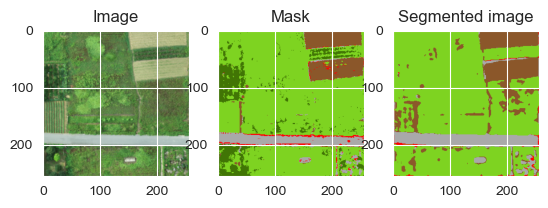

[0 2 3 4 5]


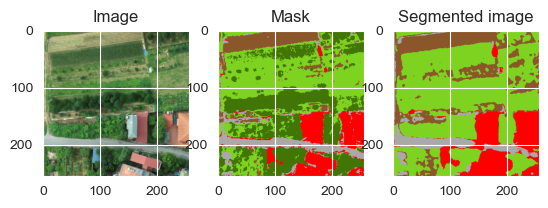

[0 2 3 4 5]


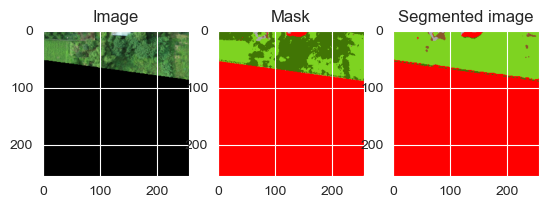

[0 1 2 3 4 5]


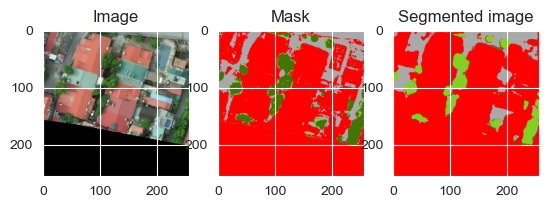

In [27]:
# test_img = cv2.imread("../dataset/256_patches_splitted/train/images/image_patch_15.tif")
# features = feature_extraction(test_img, "image")
# result = loaded_model.predict(features)
# segmented_result = result.reshape((256, 256, 1))
# print("Here  : ", np.unique(segmented_result))
# cv2.imwrite('../results/RF_test_1.tif', segmented_result)
image_directory = "../dataset/256_patches_splitted_RF/test/images"
test_directory = "../dataset/256_patches_splitted_RF/test/masks"
for subdir in os.listdir(test_directory):
    result_dir = "image" + subdir[5:]
    image = cv2.imread(image_directory + "/" + result_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(test_directory + "/" + subdir)
    result = cv2.imread("../results/UNET/" + result_dir, 0)
    print(np.unique(result))
    result = cv2.merge([result, result, result])
    rgb_result = np.zeros(result.shape, dtype=np.uint8)
    for i in range(0, 6):
        rgb_result[np.all(result == [i, i, i], axis=-1)] = color_map[i + 1]
    for i in range(0, 7):
        mask[np.all(mask == [i, i, i], axis=-1)] = color_map[i]
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask)
    plt.subplot(1, 3, 3)
    plt.title("Segmented image")
    plt.imshow(rgb_result)
    plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

18/18 [==============================] - 10s 518ms/step


 12%|█▎        | 1/8 [00:14<01:39, 14.18s/it]

18/18 [==============================] - 9s 498ms/step


 25%|██▌       | 2/8 [00:28<01:24, 14.11s/it]

18/18 [==============================] - 9s 490ms/step


 38%|███▊      | 3/8 [00:41<01:08, 13.77s/it]

18/18 [==============================] - 9s 505ms/step


 50%|█████     | 4/8 [00:55<00:55, 13.94s/it]

18/18 [==============================] - 9s 477ms/step


 62%|██████▎   | 5/8 [01:08<00:40, 13.52s/it]

18/18 [==============================] - 9s 481ms/step


 75%|███████▌  | 6/8 [01:21<00:26, 13.33s/it]

18/18 [==============================] - 9s 472ms/step


 88%|████████▊ | 7/8 [01:34<00:13, 13.07s/it]

18/18 [==============================] - 9s 483ms/step


100%|██████████| 8/8 [01:47<00:00, 13.47s/it]


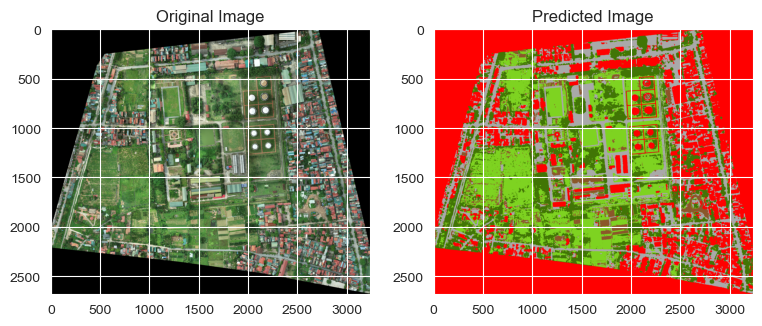

In [9]:
from smooth_blending import predict_img_with_smooth_windowing

patch_size = 256
file_path = "../scenes/01.Khoxang_H6/1_transparent_mosaic_group1_resample_03m.tif"
large_image = cv2.imread(file_path)
large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)
input_img = scaler.fit_transform(large_image.reshape(-1, large_image.shape[-1])).reshape(large_image.shape)
prediction = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)
predicted_image = np.argmax(prediction, axis=2)
predicted_image = cv2.convertScaleAbs(predicted_image)
cv2.imwrite("../results/unet.tif", predicted_image)
predicted_image = cv2.merge([predicted_image, predicted_image, predicted_image])
for i in range(0, 6):
    predicted_image[np.all(predicted_image == [i, i, i], axis=-1)] = color_map[i + 1]
plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(large_image)
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.show()